In [1]:
import sys
sys.path.append(sys.path[0] + "/..")
import similarity_matrix
import pairwisecoverage
import submodular_sim
import math
import random
import pprint
import matplotlib.pyplot as plt
import mpmath
pp = pprint.PrettyPrinter()

This note book is ment to describe some numerical findings about determining $\gamma$. The goal is to be able to estimate $\gamma$ such that $\frac{H(S)}{G(S)}\leq (1+\gamma)$ and which method of selecting $S = \{x_1,...,x_n\} $ provides us the best approximiation bound for $f$. 


Assumptions:
$f$ is submodular and monotone

Since $f$ is monotone we can take 
$$G(S) = \sum_{x_i\in S}\max\{f(x_i) -\sum_{x_j\in S_i}f(x_i)-f(x_i|x_j),0\}$$

This is reasonable because if we take $$G(S) = \sum_{x_i\in S}\left(f(x_i) - \sum_{x_j\in S_i}\left(f(x_i)-f(x_i|x_j)\right)\right)$$ can be negative and provide us extra slack we dont want to work with.

Now assumming we are able to characturize each $f(x_i)-f(x_i|x_j) \leq w_{i,j}f(x_i)$ Then we can write our equation as 

$$G(S) \geq \sum_{x_i\in S}\max\{(1-\sum_{x_k\in S_i}w_{i,k}),0\}f(x_i)$$

This function is now a monotone submodular function and therefore exist a 1/2 approximiation to $G$.

The following goes through some numerical computations computing $\gamma$.

The following function computes the set $w_{i,j}$ corresponding to the set $S$ using the overlapping circles sensor model.

In [2]:
def compute_weights(S,a,b):
    S_i = []
    weight_sets = []
    total_sum = 0
    for s in S:
        weight_sets.append([pairwisecoverage.similarity_weight(pairwisecoverage.dist(s,s_j),a,b) for s_j in S_i])
        S_i.append(s)
        total_sum += sum(weight_sets[-1])
    #print("total:",total_sum)
    #pp.pprint(weight_sets)
    return weight_sets

This function computes the value of epsilon for a given set $S = \{x_1,...,x_n\}$
$$\sum_{x_i \in S} \min \{\sum_{x_k\in S_k\backslash\{y_i^{max}\}}w_{i,k} ,1-w_i^{\max} \}f(x_i) \leq \epsilon\sum_{x_i \in S} (1-w_i^{\max})f(x_i)$$

More Specifically 

$$ \epsilon = \frac{\sum_{x_i \in S} \min \{\sum_{x_k\in S_k\backslash\{y_i^{max}\}}w_{i,k} ,1-w_i^{\max} \}f(x_i)}{\sum_{x_i \in S} (1-w_i^{\max})f(x_i)} $$

Then using this $\gamma$ can be computed using $\gamma = \frac{\epsilon}{1-\epsilon}$



In [3]:
def compute_eps_ratio_with_f(weight_sets,sim,S):
    total_LOWER = 0
    total_UPPER = 0
    avg_eps = 0 
    for i,weights in enumerate(weight_sets):
        if len(weights) == 0:
            continue
        elif len(weights)==1:
            total_UPPER += (1-weights[0])*sim.f([S[i]])
        else:
            max_weight = max(weights)
            avg_eps += (min([sum(weights)-max_weight,1-max_weight])*sim.f([S[i]]))/((1-max_weight)*sim.f([S[i]]))
            total_LOWER += min([sum(weights)-max_weight,1-max_weight])*sim.f([S[i]])
            total_UPPER += (1-max_weight)*sim.f([S[i]])
    #print("LOWER:",total_LOWER)
    #print("UPPER:",total_UPPER)
    eps = total_LOWER/total_UPPER
    #gamma = eps/(1-eps)
    #print("EPS:",eps)
    #print("1+gamma:",1+gamma)
    avg_eps = avg_eps/len(weight_sets)
    return eps

In [4]:
def compute_random_set(Xn):
    S_rand = []
    for X in Xn:
        S_rand.append(random.choice(X))
    return S_rand

def logspace(start, end, n):
    p = end/start
    return [start*math.pow(p,i/n) for i in range(n)]


The following function computes the expected distance between a point and the nth nearest sample given N points that are uniformly distributed over a cicle of radius R.

$$D_n = R\frac{\frac{\Gamma(n+\tfrac{1}{2})}{\Gamma(n)}}{\frac{\Gamma(N+1+\tfrac{1}{2})}{\Gamma(N+1)}}$$

This was taken from this paper, https://ieeexplore.ieee.org/document/5299075

The weights between two randomly sample points in a set can be then be computed using the expected distances.


In [5]:
def expected_distance(n,N,R):
    return R*(mpmath.gamma(n + 1/2)/mpmath.gamma(n))/(mpmath.gamma(N+1+1/2)/mpmath.gamma(N+1))

This function computes $\epsilon$ given a randomly selected set of points that were uniformly distributed. This also assumes that all the points selected have sensors the average area of $\frac{a+b}{2}$ where $a$ is the area of the smallest disk and $b$ is the area of the largest disk and the sizes of the disks are uniformly distributed over $[a,b]$. 

In [6]:
def compute_expected_eps(N,R,a,b):
    #R = math.sqrt(dims[0]*dims[1]/math.pi)
    total_lower = 0
    total_upper = 0
    
    #get average disk size
    f_avg = (a+b)/2
    for n in range(1,N):
        #Compute Weights for each i from 1 to n
        distances = [expected_distance(i,n,R) for i in range(1,n+1)]

        #Compute Weights given the distances
        weights = [pairwisecoverage.similarity_weight(distances[i],a,b) for i in range(n)]

        #compute denominator of epsilon equation
        total_upper +=(1-weights[0])*f_avg

        #computer Numerator of epsilon equation
        total_lower += min([sum(weights[:n+1])-weights[0],1-weights[0]])*f_avg
    
    #print("lower",total_lower)
    #print("upper",total_upper)
    eps = total_lower/total_upper
    #print(eps)
    #gamma = eps/(1-eps)
    return eps

The follow compares a randomly sampled set bound to the greedy selected set and the expected case.

In [11]:
dims = (1000,1000)
sim = submodular_sim.submodular_sim(dims=dims)
a = 500
b = 500

ns = logspace(10,2000,10)
m = 10
greedy_gammas = []
rand_gammas = []
eps_greedy = []
eps_rand = []
print(ns)
expected_eps = []
D = 100
for n in ns:
    print("computing:",int(n))
    #Xn = [[{"x":random.random()*dims[0],"y":random.random()*dims[1],'r':random.uniform(math.sqrt(a/math.pi),        math.sqrt(b/math.pi))} for _ in range(m)] for _ in range(int(n))]
    Xn = [[{"x":D*random.random()*math.cos(2*math.pi*random.random()),"y":D*random.random()*math.sin(2*math.pi*random.random()),'r':random.uniform(math.sqrt(a/math.pi),        math.sqrt(b/math.pi))} for _ in range(m)] for _ in range(int(n))]
    S = sim.similarity_weight_greedy(Xn,a,b)
    S_rand = compute_random_set(Xn)
    #compute for greedy set
    
    weights_greedy = compute_weights(S,a,b)
    ep = compute_eps_ratio_with_f(weights_greedy,sim,S)
    eps_greedy.append(ep)

    #compute for random set
    weights_rand = compute_weights(S_rand,a,b)
    ep = compute_eps_ratio_with_f(weights_rand,sim,S_rand)
    eps_rand.append(ep)
    
    expected_eps.append(compute_expected_eps(int(n),D,a,b))
print("done!")

[10.0, 16.986464646342473, 28.853998118144272, 49.012741893948984, 83.25532074018732, 141.4213562373095, 240.22488679628623, 408.0571546736738, 693.1448431551466, 1177.4080373049494]
computing: 10
computing: 16
computing: 28
computing: 49
computing: 83
computing: 141
computing: 240
computing: 408
computing: 693
computing: 1177


The following plots highlight the of how the number of points affect $\epsilon$ and therefore $1+\gamma$ and the approximation bound for the problem. Some key things to note:

* The $\epsilon$ produced by the randomly selected points relatively match the expected $\epsilon$ by random selection and therefore the paper cited works for this application. 

* The expected $\epsilon$ for random selection seems to always upperbound the $\epsilon$ for the greedy stratagy but also doesnt stray to far away from the greedy. 

* To compute $\epsilon$ for the expected case is a simple double sum that only depends on the parameters of the problem and not a solution its self. 

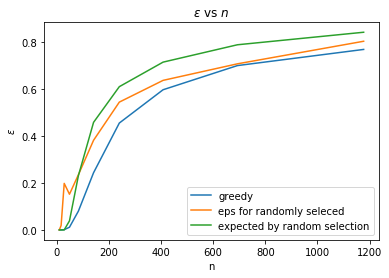

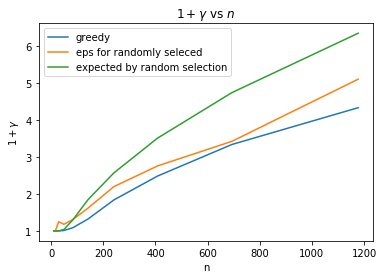

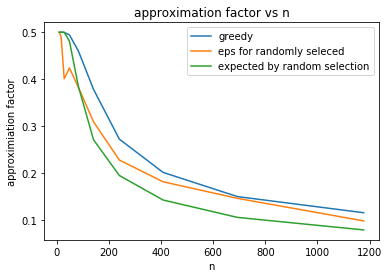

In [12]:
plt.plot(ns,eps_greedy)
plt.plot(ns,eps_rand)
plt.plot(ns,expected_eps)
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("n")
plt.ylabel(r"$\epsilon$")
plt.title(r"$\epsilon$ vs $n$")
plt.show()

plt.plot(ns,[1+ ep/(1-ep) for ep in eps_greedy])
plt.plot(ns,[1+ ep/(1-ep) for ep in eps_rand])
plt.plot(ns,[1+ ep/(1-ep) for ep in expected_eps])
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("n")
plt.ylabel(r"$1 +\gamma$")
plt.title(r"$1 + \gamma$ vs $n$")
plt.show()

plt.plot(ns,[1/(2*(1+ ep/(1-ep))) for ep in eps_greedy])
plt.plot(ns,[1/(2*(1+ ep/(1-ep))) for ep in eps_rand])
plt.plot(ns,[1/(2*(1+ ep/(1-ep))) for ep in expected_eps])
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("n")
plt.ylabel(r"approximiation factor")
plt.title(r"approximation factor vs n")
plt.show()

In [13]:
dims = (100,100)
sim = submodular_sim.submodular_sim(dims=dims)
a = 500
b = 500
n = 50
d_s= logspace(100,5000,30)
d_s = [math.sqrt(d) for d in d_s]
m = 10
greedy_gammas = []
rand_gammas = []
eps_greedy = []
eps_rand = []
print(ns)
expected_eps = []
for d in d_s:
    print("computing:",int(d))
    Xn = [[{"x":d*random.random()*math.cos(2*math.pi*random.random()),"y":d*random.random()*math.sin(2*math.pi*random.random()),'r':random.uniform(math.sqrt(a/math.pi),        math.sqrt(b/math.pi))} for _ in range(m)] for _ in range(int(n))]
    S = sim.similarity_weight_greedy(Xn,a,b)
    S_rand = compute_random_set(Xn)
    #compute for greedy set
    
    weights_greedy = compute_weights(S,a,b)
    ep = compute_eps_ratio_with_f(weights_greedy,sim,S)
    eps_greedy.append(ep)
    print(ep)

    #compute for random set
    weights_rand = compute_weights(S_rand,a,b)
    ep = compute_eps_ratio_with_f(weights_rand,sim,S_rand)
    eps_rand.append(ep)
    print(ep)
    ep =compute_expected_eps(int(n),d,a,b)
    print(ep)
    expected_eps.append(ep)
print("done!")

[10.0, 16.986464646342473, 28.853998118144272, 49.012741893948984, 83.25532074018732, 141.4213562373095, 240.22488679628623, 408.0571546736738, 693.1448431551466, 1177.4080373049494]
computing: 10
0.898414355814084
0.9670009739529761
0.9374787449911499
computing: 10
0.9050596834546588
0.9206213549320288
0.9375613472776237
computing: 11
0.7907261624596241
0.8339318197982769
0.9376558821026283
computing: 12
0.8104894215998519
0.9081993096118492
0.9377641459209551
computing: 12
0.7819148078564435
0.9795239368629506
0.9378882291345647
computing: 13
0.8192674322792362
0.8804262692591956
0.9380305720226619
computing: 14
0.8305333402197513
0.9197777491480825
0.9381940340214345
computing: 15
0.8259128316727254
0.8768170110169029
0.935239162884309
computing: 16
0.8169982273438303
0.9012357558723602
0.9285180787767263
computing: 17
0.788259295391545
0.8706972162069128
0.922388384865731
computing: 19
0.7977689933291587
0.9182680278126232
0.9168410334715232
computing: 20
0.7214956635073443
0.76312

This are showing a similar idea but instead of increasing the number of agents in the radius of the area being uniformly sampled over is increasing and the results that we expect are in play. 

* As the radius increases the $\epsilon$ decreases and therefore improving the the approximation bound. 

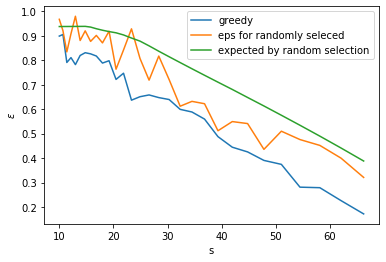

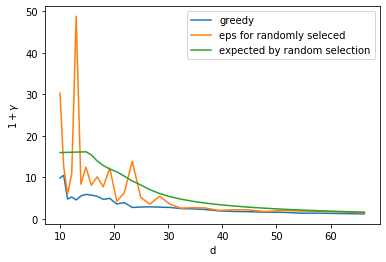

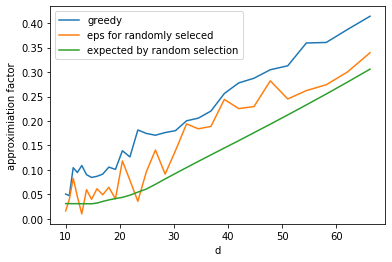

In [14]:
plt.plot(d_s,eps_greedy)
plt.plot(d_s,eps_rand)
plt.plot(d_s,expected_eps)
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("s")
plt.ylabel(r"$\epsilon$")
plt.show()

plt.plot(d_s,[1+ ep/(1-ep) for ep in eps_greedy])
plt.plot(d_s,[1+ ep/(1-ep) for ep in eps_rand])
plt.plot(d_s,[1+ ep/(1-ep) for ep in expected_eps])
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("d")
plt.ylabel(r"$1 +\gamma$")
plt.show()

plt.plot(d_s,[1/(2*(1+ ep/(1-ep))) for ep in eps_greedy])
plt.plot(d_s,[1/(2*(1+ ep/(1-ep))) for ep in eps_rand])
plt.plot(d_s,[1/(2*(1+ ep/(1-ep))) for ep in expected_eps])
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("d")
plt.ylabel("approximiation factor")
plt.show()